# Introduction to scikit-image for 3D image analysis

* Support material for the tutorial _Introduction to scikit-image for 3D image analysis_ given to the Data Umbrella community.

This tutorial will introduce how to analyze three dimensional stacked and volumetric images in Python, mainly using scikit-image and packages from the Scientific Python ecosystem. Here we will present how to:
 * pre-process data using filtering, binarization and segmentation.
 * inspect, count and measure attributes of objects and regions of interest in the data.
 * visualize large 3D data.

For more info:
  * [[scikit-image]](https://scikit-image.org/)
  * [[Data Umbrella]](https://www.dataumbrella.org/)
  * [[Data Umbrella's YouTube channel]](https://www.youtube.com/c/DataUmbrella)

Please cite [scikit-image tutorials](https://github.com/scikit-image/skimage-tutorials/) when using this material.

## What is scikit-image?

scikit-image is a collection of image processing algorithms which aims to integrate well with for the SciPy ecosystem.

It is well documented, and provides well-tested code to quickly build sophisticated image processing pipelines.


## Checking the system

First, we'll check if your system have the necessary packages.

In [1]:
%run check_setup.py

[!] You are running an unsupported version of Python. This tutorial requires Python version {PYTHON_VERSION_MAJOR}.{PYTHON_VERSION_MINOR} or newer.


SystemExit: 1

## Importing the base Scientific Python ecossystem

Let's start importing `numpy`, `matplotlib.pyplot` and `scipy.ndimage`. NumPy, SciPy and matplotlib are the core packages for the Scientific Python ecosystem.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage

# Jupyter magic: showing plots inside this notebook.
%matplotlib inline

Then, let's set a nice, `monospace` font for matplotlib's figures.

In [3]:
plt.rcParams['font.family'] = 'monospace'

## Introduction to three-dimensional image processing

In scikit-image, images are represented as `numpy` arrays.

A grayscale image, also called single-channel image, is a 2D matrix of pixel intensities of shape `(row, column)`.

Multi-channel data has an extra dimension, `channel`. In most cases, this data is in the final position, and contains color information. 

We can construct a 3D volume as a series of 2D `planes`, giving 3D images the shape `(plane, row, column)`.

Summarizing:

|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

Some 3D images are constructed with equal resolution in each dimension. An example would be a computer generated rendering of a sphere with dimensions `(30, 30, 30)`: 30 planes, 30 rows and 30 columns.

However, most experimental data captures one dimension at a lower resolution than the other two; for example, photographing thin slices to approximate a 3D structure as a stack of 2D images. We will work with one example of such data in this tutorial.


## [skimage.io](https://scikit-image.org/docs/stable/api/skimage.io.html) - utilities to read and write images in several formats<a id='io'></a>

This module helps us on reading images and saving the results. There are multiple plugins available, which support multiple formats. The most commonly used functions include:

* `io.imread`: read an image to a numpy array.
* `io.imsave`: write an image to disk.
* `io.imread_collection`: read multiple images which match a common pattern.

We can load data with `io.imread`, as in the following example.

In [4]:
from skimage import io  # skimage's I/O submodule.

In [5]:
cells = io.imread('data/cells.tif')

First let's check its shape, data type and range.

In [6]:
print(f'* "cells" shape: {cells.shape}')
print(f'* "cells" type: {cells.dtype}')
print(f'* "cells" range: {cells.min()}, {cells.max()}')

* "cells" shape: (60, 256, 256)
* "cells" type: float64
* "cells" range: 0.0, 1.0


We see that `cells` has 60 planes, each with 256 rows and 256 columns.

The default visualization function in scikit-image is `skimage.io.imshow`, but can display only grayscale and RGB(A) 2D images. We can use it to visualize 2D planes, and use some helping functions for checking 3D data.

All supplementary functions we will use during this tutorial are stored within `supplementary_code.py`. First, we import this module:

In [7]:
import supplementary_code as sc

By fixing one axis, we can observe three different views of the image. Let's use the helper function `show_plane` to do that.

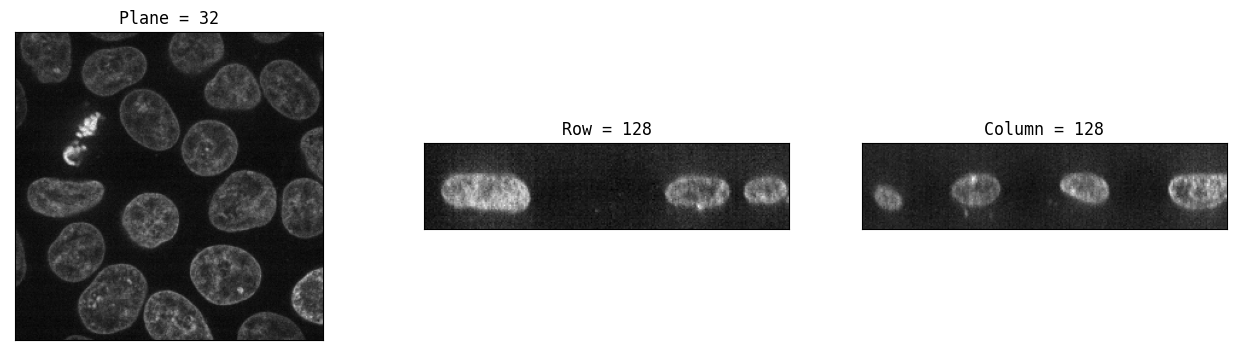

In [8]:
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

sc.show_plane(win_left, cells[32], title='Plane = 32')
sc.show_plane(win_center, cells[:, 128, :], title='Row = 128')
sc.show_plane(win_right, cells[:, :, 128], title='Column = 128')

Three-dimensional images can be viewed as a series of two-dimensional ones. The `slice_explorer` helper presents a slider to check the 2D planes.

In [9]:
sc.slice_explorer(cells)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

The `display` helper function, on the other hand, displays 30 planes of the provided image. By default, every other plane is displayed.

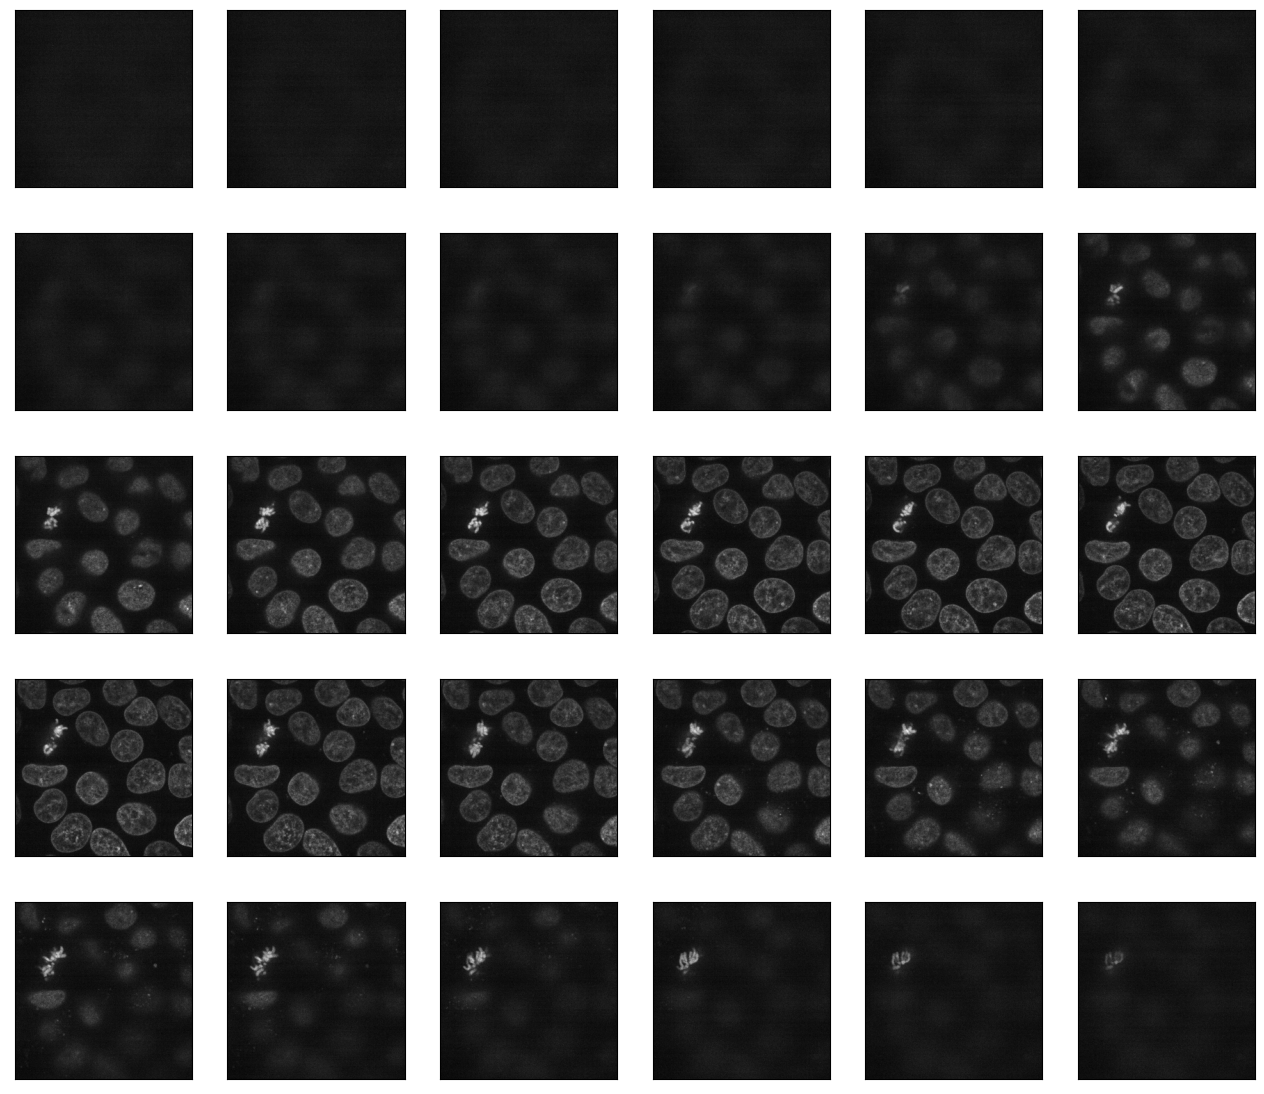

In [10]:
sc.display(cells)

## [skimage.exposure](https://scikit-image.org/docs/stable/api/skimage.exposure.html) - evaluating or changing the exposure of an image<a id='exposure'></a>

This module contains a number of functions for adjusting image contrast.

In [11]:
from skimage import exposure  # skimage's exposure module.

Most experimental images are affected by salt and pepper noise. A few bright artifacts can decrease the relative intensity of the pixels of interest. A simple way to improve contrast is to clip the pixel values on the lowest and highest extremes. Clipping the darkest and brightest 0.5% of pixels will increase the overall contrast of the image; to that end, we will use `exposure.rescale_intensity`.

In [12]:
vmin, vmax = np.percentile(cells, q=(0.5, 99.5))

cells_clipped = exposure.rescale_intensity(
    cells,
    in_range=(vmin, vmax), 
    out_range=np.float32
)

sc.slice_explorer(cells_clipped);

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

We'll call our dataset `cells_rescaled` from now on. In this cell, you can choose any of the previous results to continue working with.

In [13]:
cells_rescaled = cells_clipped

## Edge detection

[Edge detection](https://en.wikipedia.org/wiki/Edge_detection) highlights regions in the image where a sharp change in contrast occurs. The intensity of an edge corresponds to the steepness of the transition from one intensity to another. A gradual shift from bright to dark intensity results in a dim edge. An abrupt shift results in a bright edge.

The [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) is an edge detection algorithm which approximates the gradient of the image intensity, and is fast to compute.


## [skimage.filters](https://scikit-image.org/docs/stable/api/skimage.filters.html) - apply filters to an image<a id='filters'></a>

Filtering applies whole-image modifications such as sharpening or blurring. In addition to edge detection, `skimage.filters` provides functions for filtering and thresholding images.

Notable functions include (links to relevant gallery examples):

* [Thresholding](https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html):
  * `filters.threshold_*` (multiple different functions with this prefix)
  * `filters.try_all_threshold` to compare various methods
* [Edge finding/enhancement](https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html):
  * `filters.sobel` - not adapted for 3D images. It can be applied planewise to approximate a 3D result.
  * `filters.prewitt`
  * `filters.scharr`
  * `filters.roberts`
  * `filters.laplace`
  * `filters.hessian`
* [Ridge filters](https://scikit-image.org/docs/stable/auto_examples/edges/plot_ridge_filter.html):
  * `filters.meijering`
  * `filters.sato`
  * `filters.frangi`
* Inverse filtering (see also [skimage.restoration](#restoration)):
  * `filters.weiner`
  * `filters.inverse`
* [Directional](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html): `filters.gabor`
* Blurring/denoising
  * `filters.gaussian`
  * `filters.median`
* [Sharpening](https://scikit-image.org/docs/stable/auto_examples/filters/plot_unsharp_mask.html): `filters.unsharp_mask`
* Define your own filter: `LPIFilter2D`
  
The sub-submodule `skimage.filters.rank` contains rank filters. These filters are nonlinear and operate on the local histogram.

In [14]:
from skimage import filters  # skimage's filtering module

In [15]:
cells_sobel = np.empty_like(cells_rescaled)

for plane, image in enumerate(cells_rescaled):
    cells_sobel[plane] = filters.sobel(image)
    
sc.slice_explorer(cells_sobel)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

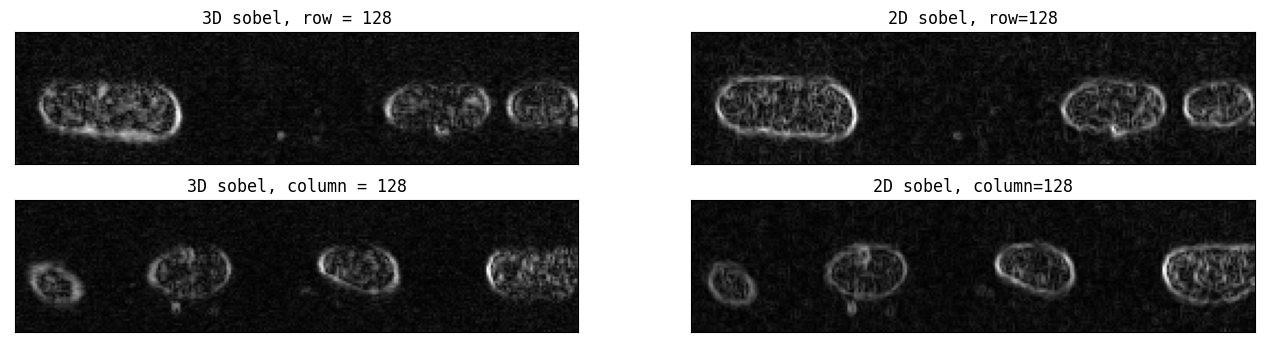

In [16]:
_, ((win_top_left, win_top_right),
    (win_bottom_left, win_bottom_right)) = plt.subplots(nrows=2,
                                                        ncols=2,
                                                        figsize=(16, 4))

sc.show_plane(win_top_left, cells_sobel[:, 128, :], title='3D sobel, row = 128')

cells_sobel_row = filters.sobel(cells_rescaled[:, 128, :])
sc.show_plane(win_top_right, cells_sobel_row, title='2D sobel, row=128')

sc.show_plane(win_bottom_left, cells_sobel[:, :, 128], title='3D sobel, column = 128')

cells_sobel_col = filters.sobel(cells_rescaled[:, :, 128])
sc.show_plane(win_bottom_right, cells_sobel_col, title='2D sobel, column=128')

## [skimage.transform](https://scikit-image.org/docs/stable/api/skimage.transform.html) - transforms & warping<a id='transform'></a>

This submodule has multiple features which fall under the umbrella of transformations.

Forward (`radon`) and inverse (`iradon`) radon transforms, as well as some variants (`iradon_sart`) and the finite versions of these transforms (`frt2` and `ifrt2`).  These are used for [reconstructing medical computed tomography (CT) images](https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html).

Hough transforms for identifying lines, circles, and ellipses.

Changing image size, shape, or resolution with `resize`, `rescale`, or `downscale_local_mean`.

`warp`, and `warp_coordinates` which take an image or set of coordinates and translate them through one of the defined `*Transforms` in this submodule.  `estimate_transform` may be assist in estimating the parameters.

[Numerous gallery examples are available](https://scikit-image.org/docs/stable/auto_examples/index.html#geometrical-transformations-and-registration) illustrating these functions.  [The panorama tutorial also includes warping](./solutions/adv3_panorama-stitching-solution.ipynb) via `SimilarityTransform` with parameter estimation via `measure.ransac`.

In [17]:
from skimage import transform  # skimage's transform submodule.

We created the illustration below to illustrate the downsampling operation. The red dots show the pixels within each image.

Text(0.5, 1.0, 'Downsampled: (2, 2)')

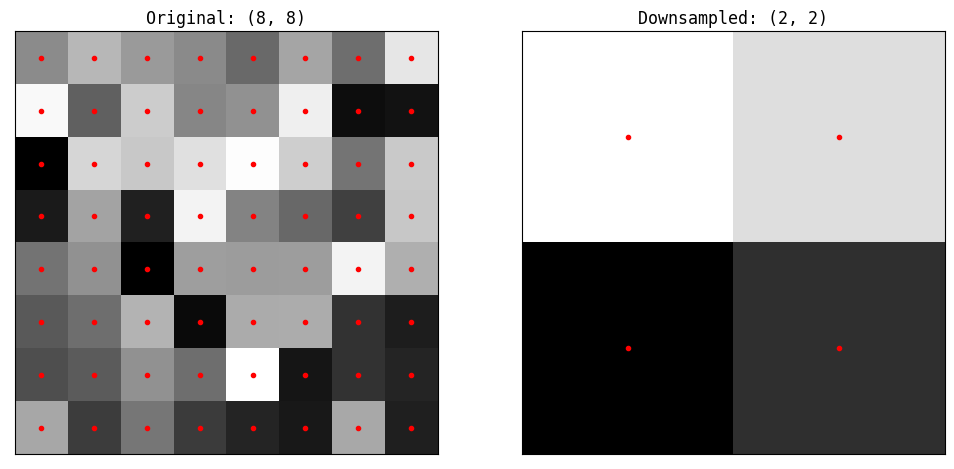

In [18]:
# To make sure we all see the same thing, let's set a seed
np.random.seed(0)

image = np.random.random((8, 8))
image_rescaled = transform.downscale_local_mean(image, (4, 4))

_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

win_left.imshow(image, cmap='gray')
win_left.set_xticks([])
win_left.set_yticks([])
centers = np.indices(image.shape).reshape(2, -1).T
win_left.plot(centers[:, 0], centers[:, 1], '.r')
win_left.set_title(f'Original: {image.shape}')

win_right.imshow(image_rescaled, cmap='gray')
win_right.set_xticks([])
win_right.set_yticks([])
centers = np.indices(image_rescaled.shape).reshape(2, -1).T
win_right.plot(centers[:, 0], centers[:, 1], '.r');
win_right.set_title(f'Downsampled: {image_rescaled.shape}')

The distance between pixels in each dimension, called `spacing`, is encoded in a tuple and is accepted as a parameter by some `skimage` functions and can be used to adjust contributions to filters.

The distance between pixels was reported by the microscope used to image the cells. This `spacing` information will be used to adjust contributions to filters and helps decide when to apply operations planewise. We've chosen to downsample each slice by a factor of 4 in the `row` and `column` dimensions to make the data smaller, thus reducing computational time. We also normalize it to `1.0` in the `row` and `column` dimensions.

In [19]:
# The microscope reports the following spacing:
original_spacing = np.array([0.2900000, 0.0650000, 0.0650000])
print(f'* Microscope original spacing: {original_spacing}')

# We downsampled each slice 4x to make the data smaller
rescaled_spacing = original_spacing * [1, 4, 4]
print(f'* Microscope after rescaling images: {rescaled_spacing}')

# Normalize the spacing so that pixels are a distance of 1 apart
spacing = rescaled_spacing / rescaled_spacing[2]
print(f'* Microscope normalized spacing: {spacing}')

* Microscope original spacing: [0.29  0.065 0.065]
* Microscope after rescaling images: [0.29 0.26 0.26]
* Microscope normalized spacing: [1.11538462 1.         1.        ]


## Filters

[Median filter](https://en.wikipedia.org/wiki/Median_filter) is a noise removal filter. It is particularly effective against salt and pepper noise. An additional feature of the median filter is its ability to preserve edges. This is helpful in segmentation because the original shape of regions of interest will be preserved.

`skimage.filters.median` does not support three-dimensional images and needs to be applied planewise.

## [skimage.util](https://scikit-image.org/docs/stable/api/skimage.util.html) - utility functions<a id='util'></a>

These are generally useful functions which have no definite other place in the package.

* `util.img_as_*` are convenience functions for datatype conversion.

* `util.invert` is a convenient way to invert any image, accounting for its datatype.

* `util.random_noise` is a comprehensive function to apply any amount of many different types of noise to images.  The seed may be set, resulting in pseudo-random noise for testing.

* `util.view_as_*` allows for overlapping views into the same memory array, which is useful for elegant local computations with minimal memory impact.

* `util.apply_parallel` uses Dask to apply a function across subsections of an image.  This can result in dramatic performance or memory improvements, but depending on the algorithm edge effects or lack of knowledge of the remainder of the image may result in unexpected results.

* `util.pad` and `util.crop` pads or crops the edges of images.  `util.pad` is now a direct wrapper for `numpy.pad`.

In [20]:
from skimage import util  # skimage's util submodule.

In [21]:
cells_rescaled_ubyte = util.img_as_ubyte(cells_rescaled)

cells_median = np.empty_like(cells_rescaled_ubyte)

for plane, image in enumerate(cells_rescaled_ubyte):
    cells_median[plane] = filters.median(image)

cells_median = util.img_as_float(cells_median)

sc.slice_explorer(cells_median);

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

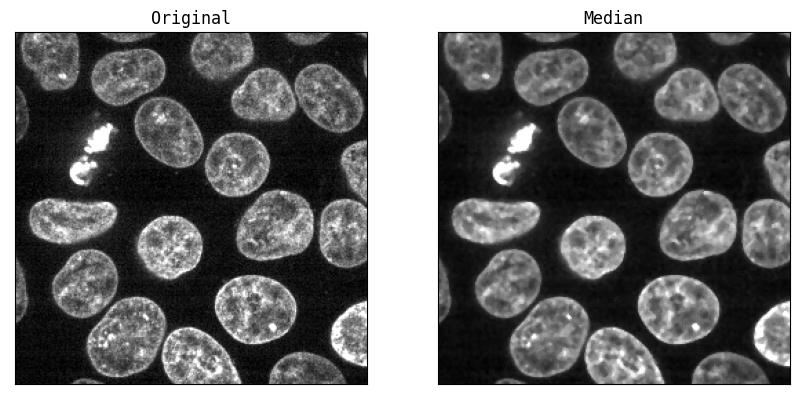

In [22]:
_, (win_top_left, win_top_right) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

sc.show_plane(win_top_left, cells_rescaled[32], title='Original')
sc.show_plane(win_top_right, cells_median[32], title='Median')

In [23]:
cells_denoised = cells_median

## Thresholding

[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. Thresholding is a form of image segmentation.

Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and Li's minimum cross entropy threshold are two common algorithms. The example below demonstrates how a small difference in the threshold value can visibly alter the binarized image.

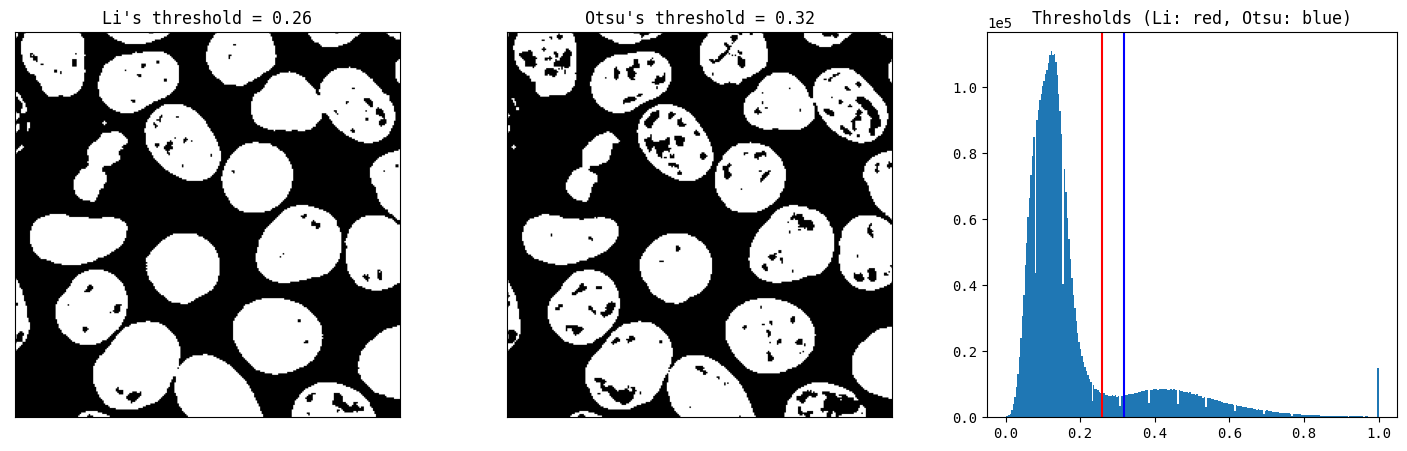

In [24]:
threshold_li = filters.threshold_li(cells_denoised)
cells_binary_li = cells_denoised >= threshold_li

threshold_otsu = filters.threshold_otsu(cells_denoised)
cells_binary_otsu = cells_denoised >= threshold_otsu

_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sc.show_plane(win_left,
              cells_binary_li[32],
              title='Li\'s threshold = {:0.2}'.format(threshold_li))
sc.show_plane(win_center,
              cells_binary_otsu[32],
              title='Otsu\'s threshold = {:0.2}'.format(threshold_otsu))

sc.plot_hist(win_right, cells_denoised, 'Thresholds (Li: red, Otsu: blue)')
win_right.axvline(threshold_li, c='r')
win_right.axvline(threshold_otsu, c='b')

In [25]:
cells_binary = cells_binary_li

sc.slice_explorer(cells_binary)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

## <a id='morphology'></a>[skimage.morphology](https://scikit-image.org/docs/stable/api/skimage.morphology.html) - binary and grayscale morphology

Morphological image processing is a collection of non-linear operations related to the shape or morphology of features in an image, such as boundaries, skeletons, etc. In any given technique, we probe an image with a small shape or template called a structuring element, which defines the region of interest or neighborhood around a pixel.

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`. Structuring elements are shapes which define areas over which an operation is applied. The response to the filter indicates how well the neighborhood corresponds to the structuring element's shape.

In [26]:
from skimage import morphology  # skimage's morphological submodules.

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. Both functions accept a `min_size` parameter, which is the minimum size (in pixels) of accepted holes or objects. The `min_size` can be approximated by a cube.

In [27]:
width = 20

cells_remove_holes = morphology.remove_small_holes(
    cells_binary,
    width ** 3
)

sc.slice_explorer(cells_remove_holes);

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

In [28]:
width = 20

cells_remove_objects = morphology.remove_small_objects(
    cells_remove_holes, 
    min_size=width ** 3
)

sc.slice_explorer(cells_remove_objects);

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

## <a id='measure'></a>[skimage.measure](https://scikit-image.org/docs/stable/api/skimage.measure.html) - measuring image or region properties

Multiple algorithms to label images, or obtain information about discrete regions of an image.

* `measure.label` - Label an image, i.e. identify discrete regions in the image using unique integers.
* `measure.regionprops` - In a labeled image, as returned by `label`, find various properties of the labeled regions.

Finding paths from a 2D image, or isosurfaces from a 3D image.

* `measure.find_contours`
* `measure.marching_cubes_lewiner`
* `measure.marching_cubes_classic`
* `measure.mesh_surface_area` - Surface area of 3D mesh from marching cubes.
* `measure.compare_*` - Quantify the difference between two whole images; often used in denoising or restoration.

**RANDom Sample Consensus fitting (RANSAC)** - a powerful, robust approach to fitting a model to data.  It exists here because its initial use was for fitting shapes, but it can also fit transforms.
* `measure.ransac`
* `measure.CircleModel`
* `measure.EllipseModel`
* `measure.LineModelND`

[Image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) partitions images into regions of interest. Integer labels are assigned to each region to distinguish regions of interest.

Connected components of the binary image are assigned the same label via `skimage.measure.label`. Tightly packed cells  connected in the binary image are assigned the same label.

In [29]:
from skimage import measure  # skimage's measure submodule.

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

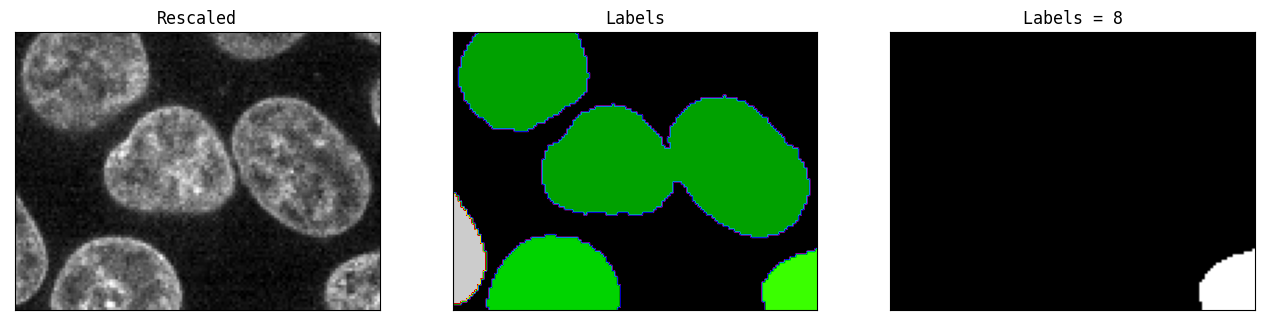

In [30]:
cells_labels = measure.label(cells_remove_objects)

sc.slice_explorer(cells_labels, cmap='nipy_spectral');

_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

sc.show_plane(win_left, cells_rescaled[32, :100, 125:], title='Rescaled')
sc.show_plane(win_center, cells_labels[32, :100, 125:], cmap='nipy_spectral', title='Labels')
sc.show_plane(win_right, cells_labels[32, :100, 125:] == 8, title='Labels = 8')

A better segmentation would assign different labels to disjoint regions in the original image. 

[Watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) can distinguish touching objects. Markers are placed at local minima and expanded outward until there is a collision with markers from another region. The inverse intensity image transforms bright cell regions into basins which should be filled.

In declumping, markers are generated from the distance function. Points furthest from an edge have the highest intensity and should be identified as markers using `skimage.feature.peak_local_max`. Regions with pinch points should be assigned multiple markers.

In [31]:
cells_distance = ndimage.distance_transform_edt(cells_remove_objects)

sc.slice_explorer(cells_distance, cmap='viridis');

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

## [skimage.feature](https://scikit-image.org/docs/stable/api/skimage.feature.html) - extract features from an image<a id='feature'></a>

This submodule presents a diverse set of tools to identify or extract certain features from images, including tools for

* Edge detection: `feature.canny`
* Corner detection:
  * `feature.corner_kitchen_rosenfeld`
  * `feature.corner_harris`
  * `feature.corner_shi_tomasi`
  * `feature.corner_foerstner`
  * `feature.subpix`
  * `feature.corner_moravec`
  * `feature.corner_fast`
  * `feature.corner_orientations`
* Blob detection
  * `feature.blob_dog`
  * `feature.blob_doh`
  * `feature.blob_log`
* Texture
  * `feature.greycomatrix`
  * `feature.greycoprops`
  * `feature.local_binary_pattern`
  * `feature.multiblock_lbp`
* Peak finding: `feature.peak_local_max`
* Object detction
  * `feature.hog`
  * `feature.match_template`
* Stereoscopic depth estimation: `feature.daisy`
* Feature matching
  * `feature.ORB`
  * `feature.BRIEF`
  * `feature.CENSURE`
  * `feature.match_descriptors`
  * `feature.plot_matches`


In [32]:
from skimage import feature  # skimage's feature submodule.

## <a id='segmentation'></a>[skimage.segmentation](https://scikit-image.org/docs/stable/api/skimage.segmentation.html) - identification of regions of interest

One of the key image analysis tasks is identifying regions of interest.  These could be a person, an object, certain features of an animal, microscopic image, or stars.  Segmenting an image is the process of determining where these things you want are in your images.

Segmentation has two overarching categories:

**Supervised** - must provide some guidance (seed points or initial conditions)

* `segmentation.random_walker`
* `segmentation.active_contour`
* `segmentation.watershed`
* `segmentation.flood_fill`
* `segmentation.flood`

**Unsupervised** - no human input

* `segmentation.slic`
* `segmentation.felzenszwalb`
* `segmentation.chan_vese`

There are also some supervised and unsupervised thresholding algorithms in `filters`. There is a [segmentation lecture](https://github.com/scikit-image/skimage-tutorials/blob/main/lectures/4_segmentation.ipynb) ([and its solution](https://github.com/scikit-image/skimage-tutorials/blob/main/lectures/solutions/4_segmentation.ipynb)) you may peruse, as well as many [gallery examples](https://scikit-image.org/docs/stable/auto_examples/index.html#segmentation-of-objects) which illustrate all of these segmentation methods.

[Feature extraction](https://en.wikipedia.org/wiki/Feature_extraction) reduces data required to describe an image or objects by measuring informative features. These include features such as area or volume, bounding boxes, and intensity statistics.

Before measuring objects, it helps to clear objects from the image border. Measurements should only be collected for objects entirely contained in the image.

In [33]:
from skimage import segmentation  # skimage's segmentation submodule.

In [34]:
peak_local_max = feature.peak_local_max(
    cells_distance,
    footprint=np.ones((15, 15, 15), dtype=bool),
    indices=False,
    labels=measure.label(cells_remove_objects)
)

cells_markers = measure.label(peak_local_max)

cells_labels = segmentation.watershed(
    cells_rescaled, 
    cells_markers, 
    mask=cells_remove_objects
)

sc.slice_explorer(cells_labels, cmap='nipy_spectral');

/var/home/alex/mambaforge/envs/dataumbrella_skimage/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  """


interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

After watershed, we have better disambiguation between internal cells.

When cells simultaneous touch the border of the image, they may be assigned the same label.  In pre-processing, we typically remove these cells.

**Note:** This is 3D data -- you may not always be able to see connections in 2D!

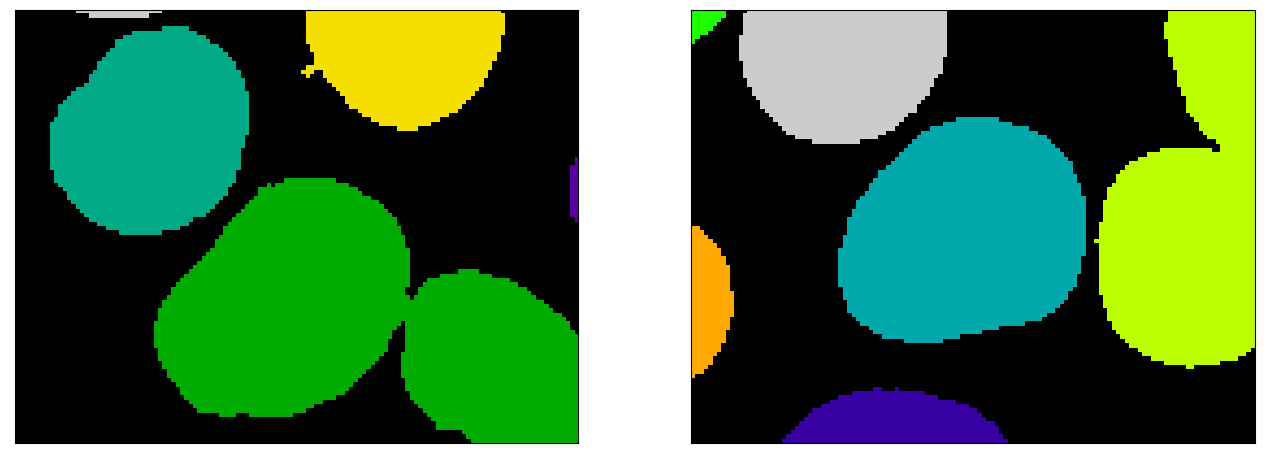

In [35]:
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sc.show_plane(win_left, cells_labels[39, 156:, 20:150], cmap='nipy_spectral')
sc.show_plane(win_right, cells_labels[34, 90:190, 126:], cmap='nipy_spectral')

The watershed algorithm falsely detected subregions in a few cells. This is referred to as oversegmentation.

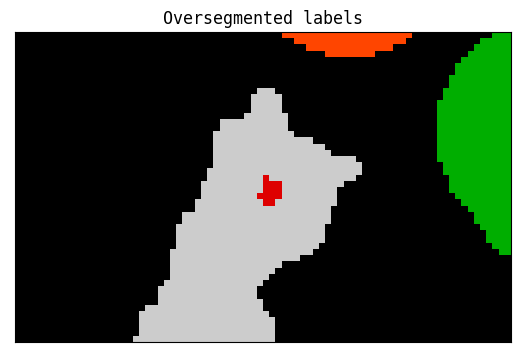

In [36]:
_, axis = plt.subplots()
sc.show_plane(axis,
              cells_labels[38, 50:100, 20:100],
              cmap='nipy_spectral',
              title='Oversegmented labels')

Plotting the markers on the distance image reveals the reason for oversegmentation. Cells with multiple markers will be assigned multiple labels, and oversegmented. It can be observed that cells with a uniformly increasing distance map are assigned a single marker near their center. Cells with uneven distance maps are assigned multiple markers, indicating the presence of multiple local maxima.

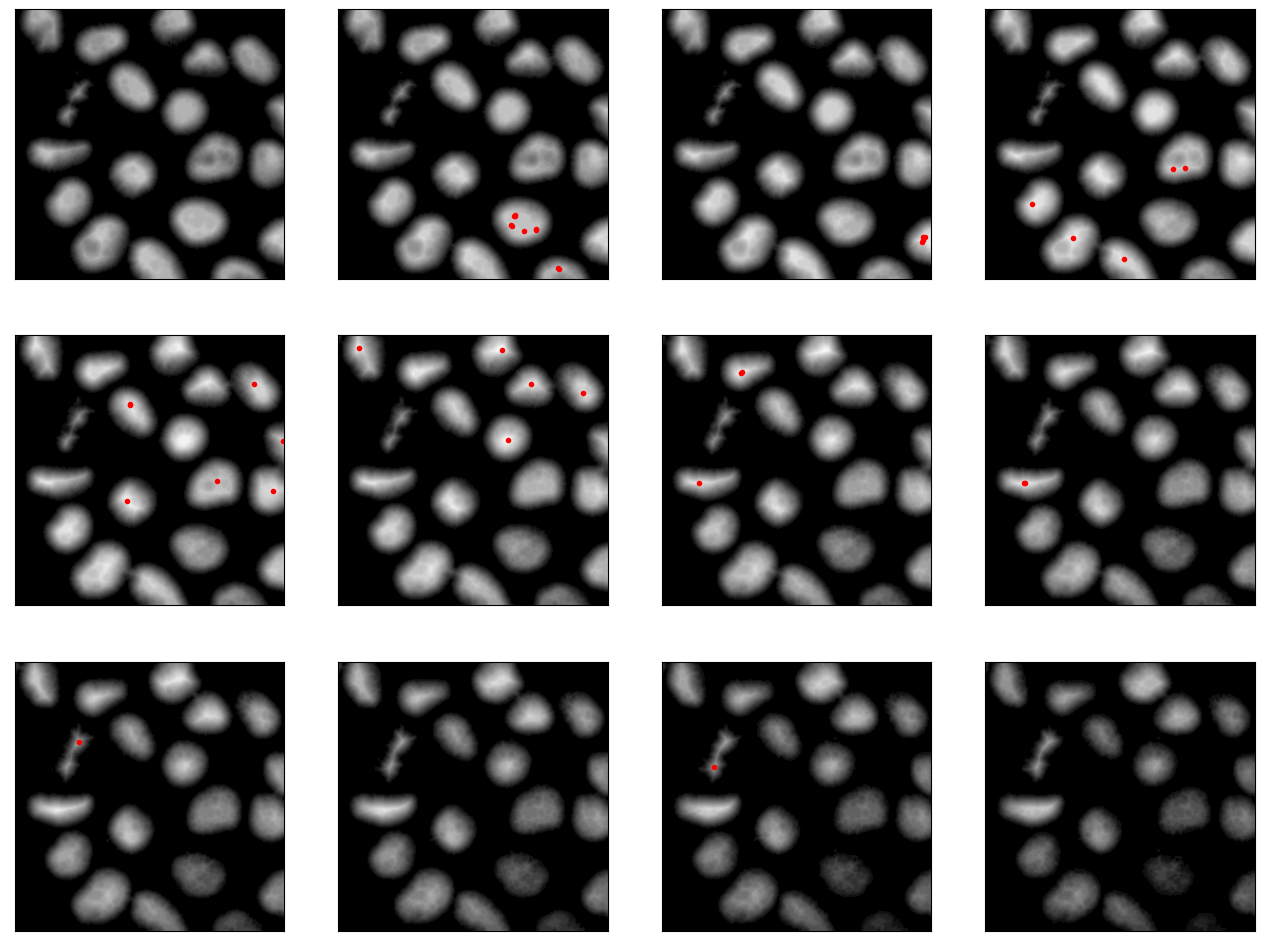

In [37]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

vmin = cells_distance.min()
vmax = cells_distance.max()

offset = 31

for index, ax in enumerate(axes.flatten()):
    ax.imshow(
        cells_distance[offset + index],
        cmap='gray',
        vmin=vmin,
        vmax=vmax
    )
    
    peaks = np.nonzero(peak_local_max[offset + index])
    
    ax.plot(peaks[1], peaks[0], 'r.')
    ax.set_xticks([])
    ax.set_yticks([])

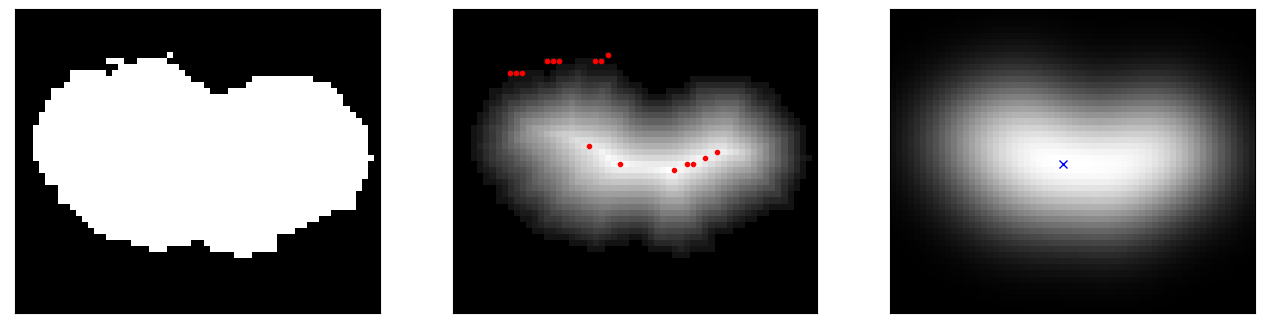

In [38]:
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))


sc.show_plane(win_left, cells_remove_objects[10:, 193:253, 74])
sc.show_plane(win_center, cells_distance[10:, 193:253, 74])

features = feature.peak_local_max(cells_distance[10:, 193:253, 74])
win_center.plot(features[:, 1], features[:, 0], 'r.')

# Improve feature selection by blurring, using a larger footprint
# in `peak_local_max`, etc.

smooth_distance = filters.gaussian(cells_distance[10:, 193:253, 74], sigma=5)
sc.show_plane(win_right, smooth_distance)
features = feature.peak_local_max(
    smooth_distance
)
win_right.plot(features[:, 1], features[:, 0], 'bx');

In [39]:
cells_labels_inner = segmentation.clear_border(cells_labels)
cells_labels_inner = morphology.remove_small_objects(cells_labels_inner, min_size=200)

print(f'Interior labels: {np.unique(cells_labels_inner)}')

sc.slice_explorer(cells_labels_inner, cmap='nipy_spectral');

Interior labels: [ 0  3  8 10 14 18 23 24 25]


interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

After clearing the border, the object labels are no longer sequentially increasing. The labels can be renumbered such that there are no jumps in the list of image labels:

In [40]:
cells_relabeled, _, _ = segmentation.relabel_sequential(cells_labels_inner)

print(f'Relabeled labels: {np.unique(cells_relabeled)}')

Relabeled labels: [0 1 2 3 4 5 6 7 8]


`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. It's good practice to make measurements on the original image.

Not all properties are supported for 3D data. Below are lists of supported and unsupported 3D measurements.

In [41]:
properties = measure.regionprops(cells_relabeled,
                                 intensity_image=cells)
props_first_region = properties[0]

supported = [''] 
unsupported = ['']

for prop in props_first_region:
    try:
        props_first_region[prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print('Supported properties:')
print('\n\t'.join(supported))
print()
print('Unsupported properties:')
print('\n\t'.join(unsupported))

Supported properties:

	area
	area_bbox
	area_convex
	area_filled
	axis_major_length
	axis_minor_length
	bbox
	centroid
	centroid_local
	centroid_weighted
	centroid_weighted_local
	coords
	equivalent_diameter_area
	euler_number
	extent
	feret_diameter_max
	image
	image_convex
	image_filled
	image_intensity
	inertia_tensor
	inertia_tensor_eigvals
	intensity_max
	intensity_mean
	intensity_min
	label
	moments
	moments_central
	moments_normalized
	moments_weighted
	moments_weighted_central
	moments_weighted_normalized
	slice
	solidity

Unsupported properties:

	eccentricity
	moments_hu
	moments_weighted_hu
	orientation
	perimeter
	perimeter_crofton


`skimage.measure.regionprops` ignores the label `0`, which represents the background.

In [42]:
print(f'Measured regions: {[prop.label for prop in properties]}')

Measured regions: [1, 2, 3, 4, 5, 6, 7, 8]


In [43]:
cells_volumes = [prop.area for prop in properties]

print(f'Total pixels: {cells_volumes}')

Total pixels: [48806, 47480, 40182, 40516, 42496, 40032, 37450, 48160]


Collected measurements can be further reduced by computing per-image statistics such as total, minimum, maximum, mean, and standard deviation.

In [44]:
print('Volume statistics\n')
print(f' * Total: {np.sum(cells_volumes)}')
print(f' * Min: {np.min(cells_volumes)}')
print(f' * Max: {np.max(cells_volumes)}')
print(' * Mean: {:0.2f}'.format(np.mean(cells_volumes)))
print(' * Standard deviation: {:0.2f}'.format(np.std(cells_volumes)))

Volume statistics

 * Total: 345122
 * Min: 37450
 * Max: 48806
 * Mean: 43140.25
 * Standard deviation: 4096.11


## Visualization

After cleaning, separating and studying the regions within the data, it's time to visualize them.

We can use the perimeters of a region to generate their plots. However, perimeter measurements are not computed for 3D objects. Using the fact that 3D extension of perimeter is surface area, we can measure the surface of an object by generating a surface mesh with `skimage.measure.marching_cubes` and computing the surface area of the mesh with `skimage.measure.mesh_surface_area`. The function `plot_3d_surface` has it covered:

Surface area

 * Total pixels: 6927.62
 * Actual: 7463.14


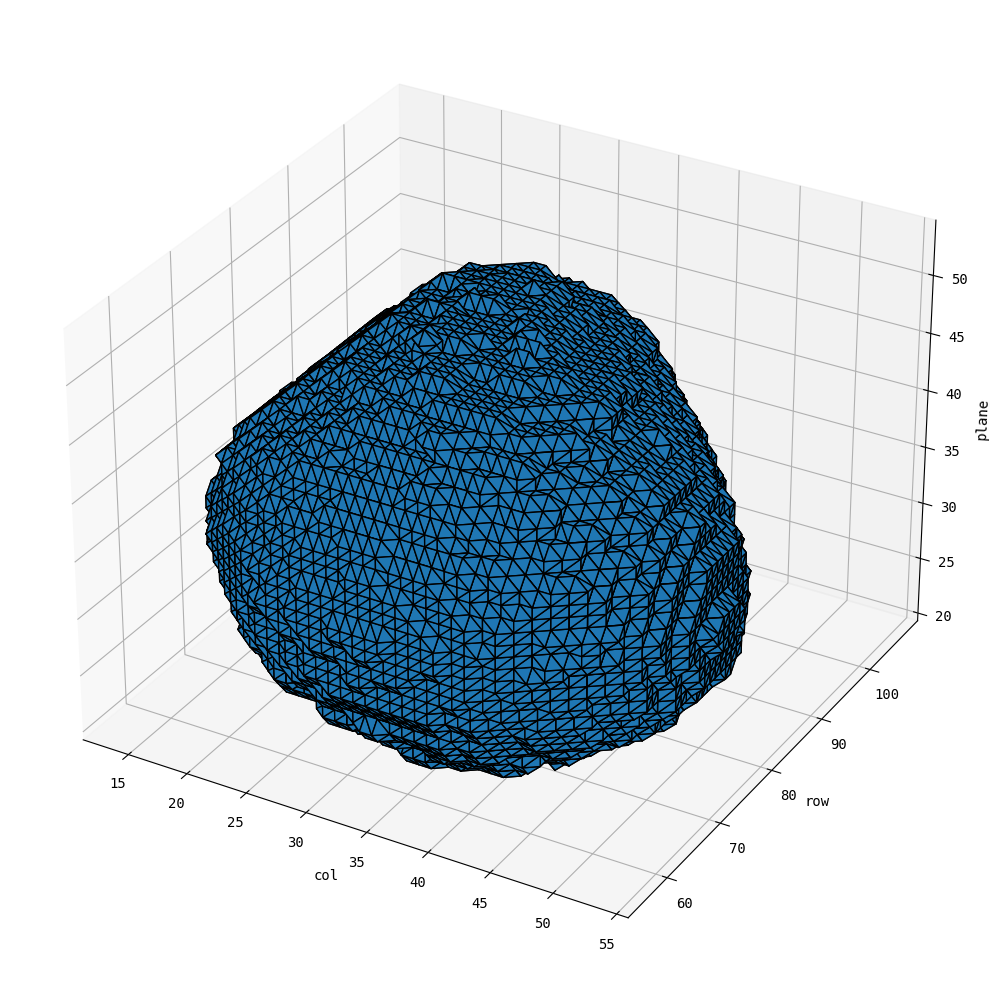

In [45]:
sc.plot_3d_surface(data=cells,
                   labels=cells_relabeled,
                   region=6,
                   spacing=spacing)

Now let's generate a full, interactive 3D plot using ITK and `itkwidgets`:

In [46]:
import itk
from itkwidgets import view

To generate a 3D plot using ITK, we need to reformat the numpy array into an ITK matrix using `GetImageFromArray`. Then, we use `itkwidgets.view`:

In [47]:
cells_itk_image = itk.GetImageFromArray(util.img_as_ubyte(cells_relabeled))
view(cells_itk_image)

Downcasting int32 to uint8 without scaling because max value 8 fits in uint8


Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

## Going beyond

[1] A tour/guide on scikit-image's submodules: https://github.com/scikit-image/skimage-tutorials/blob/main/lectures/tour_of_skimage.ipynb

[2] scikit-image's gallery examples: https://scikit-image.org/docs/stable/auto_examples/

[3] ITK's `ikwidgets`: https://github.com/InsightSoftwareConsortium/itkwidgets